## 0. 기본적인 데이터 준비 단계
### 0-1 준비 및 데이터 설정

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
sns.set_style("whitegrid")

import warnings
warnings.filterwarnings("ignore")

from scipy.stats import ttest_ind, mannwhitneyu

In [2]:
df = pd.read_csv('train.csv', encoding='ISO-8859-1')

### 0-2 is_converted 칼럼 정리

In [3]:
#1. is_converted가 NA인 데이터 drop
original_rows = len(df)
df = df.dropna(subset=['is_converted'])
erased_rows = original_rows - len(df)
print('지워진 행: '+str(erased_rows))

지워진 행: 0


In [4]:
print('is_converted unique values:')
df.is_converted.unique()

is_converted unique values:


array([ True, False])

In [5]:
# is_converted 의 값들 정리
# 모두 TRUE or FALSE로 통일, 이외값을 가진 행은 제거
df['is_converted'] = df['is_converted'].astype(str).str.upper()
df = df[df['is_converted'].isin(['TRUE', 'FALSE'])]
print('지워진 행: '+ str(original_rows-erased_rows-len(df)))

지워진 행: 0


### 0-3 중복 행 처리

In [6]:
df.drop_duplicates(keep='first', inplace=True)
len(df)

55780

## 1. 100% 차있는 column 처리

In [7]:
for col in df.columns:
    if df[col].isnull().sum() == 0:
        print(col)

bant_submit
business_unit
customer_idx
enterprise
lead_desc_length
customer_position
response_corporate
ver_cus
ver_pro
lead_owner
is_converted


### 1-1 bant_submit

In [8]:
df.bant_submit.unique()

array([1.  , 0.75, 0.5 , 0.25, 0.  ])

## 2 칼럼별 처리 (NA율 > 90%)

### 2-1 id_strategic_ver, it_strategic_ver, idit_strategic_ver

In [48]:
dropped_columns = []
for col in df.columns:
    if df[col].isnull().sum()/len(df)*100 > 90:
        print(col)

id_strategic_ver
it_strategic_ver
idit_strategic_ver
business_subarea


In [49]:
# idit_strategic_ver 으로 다 되기 때문에 id_strategic_ver, it_strategic_ver 제거

df.drop(columns='id_strategic_ver', inplace=True, axis=1)
df.drop(columns='it_strategic_ver', inplace=True, axis=1)
df.idit_strategic_ver.fillna(0, inplace=True)

print(df.idit_strategic_ver.unique())
df.columns

[0. 1.]


Index(['bant_submit', 'customer_country', 'business_unit',
       'com_reg_ver_win_rate', 'customer_idx', 'customer_type', 'enterprise',
       'historical_existing_cnt', 'idit_strategic_ver', 'customer_job',
       'lead_desc_length', 'inquiry_type', 'product_category',
       'product_subcategory', 'product_modelname', 'customer_country.1',
       'customer_position', 'response_corporate', 'expected_timeline',
       'ver_cus', 'ver_pro', 'ver_win_rate_x', 'ver_win_ratio_per_bu',
       'business_area', 'business_subarea', 'lead_owner', 'is_converted'],
      dtype='object')

### 2-2 business_subarea

In [50]:
df.business_subarea.fillna('NA', inplace=True)
print('na values in business_subarea: '+str(df['business_subarea'].isna().sum()))
print('number of unique values in business_subarea: '+str(len(df['business_subarea'].unique())))
print(df['business_subarea'].value_counts())

print(df['business_subarea'].unique())

na values in business_subarea: 0
number of unique values in business_subarea: 87
business_subarea
NA                               50600
Others                            1585
Other Stores                       270
Hospital                           245
Manufacturing Factory / Plant      190
                                 ...  
Duty Free Shop                       2
Dormitory                            1
Casino Resort                        1
Holdings                             1
Travel Agency                        1
Name: count, Length: 87, dtype: int64
['Engineering' 'Advertising' 'Construction' 'IT/Software' 'NA'
 'Manufacturing' 'Energy' 'Developer/Property' 'Entertainment'
 'Agriculture' 'Pharmaceutical' 'Others' 'Banking' 'Consulting'
 'Healthcare' 'Finance' 'Broadcasting & Media' 'Distribution Center'
 'Law Firm' 'Logistics' 'Telecommunication' 'Aerospace' 'Network/Cabling'
 'Insurance' 'Institute & Academy' 'Hotel' 'K12 Kindergarten & Schools'
 'Hospital' 'Mixed-use (Multi 

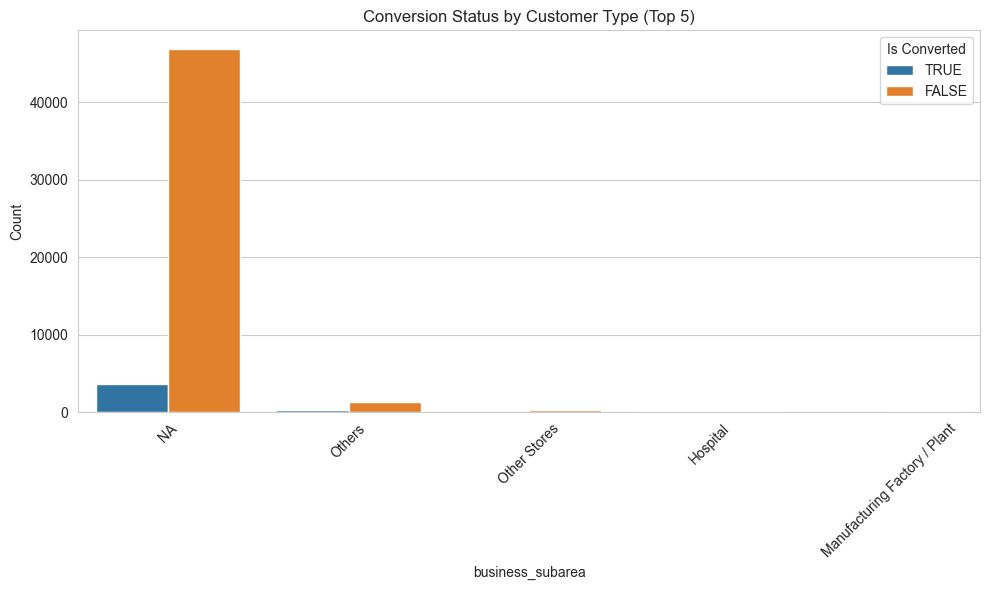

In [51]:
#compare the values of two columns by printing the columns
df.business_subarea.value_counts()

top_5_customer_types = df['business_subarea'].value_counts().nlargest(5).index

# Filter the DataFrame to keep only rows with the top 5 'customer_type' values
df_top_5_customer_types = df[df['business_subarea'].isin(top_5_customer_types)]

# Create a count plot for the filtered DataFrame
plt.figure(figsize=(10, 6))
sns.countplot(data=df_top_5_customer_types, x='business_subarea', hue='is_converted', 
              order=df_top_5_customer_types['business_subarea'].value_counts().index)

plt.xticks(rotation=45)  # Rotate the x-axis labels for better readability
plt.xlabel('business_subarea')
plt.ylabel('Count')
plt.title('Conversion Status by Customer Type (Top 5)')
plt.legend(title='Is Converted', loc='upper right')

plt.tight_layout()  # Adjust layout to make sure everything fits without overlapping
plt.show()

In [52]:
df.drop(columns='business_subarea', inplace=True, axis=1)
len(df.columns)
df.columns

Index(['bant_submit', 'customer_country', 'business_unit',
       'com_reg_ver_win_rate', 'customer_idx', 'customer_type', 'enterprise',
       'historical_existing_cnt', 'idit_strategic_ver', 'customer_job',
       'lead_desc_length', 'inquiry_type', 'product_category',
       'product_subcategory', 'product_modelname', 'customer_country.1',
       'customer_position', 'response_corporate', 'expected_timeline',
       'ver_cus', 'ver_pro', 'ver_win_rate_x', 'ver_win_ratio_per_bu',
       'business_area', 'lead_owner', 'is_converted'],
      dtype='object')

## 3 칼럼별 처리 (NA율 > 50%)

In [53]:
#칼럼별 NA율이 50% 이상인 칼럼 나열
for col in df.columns:
    if df[col].isnull().sum()/len(df)*100 > 50:
        print(col, df[col].isnull().sum()/len(df)*100)
        #df.drop(col, axis=1, inplace=True)

com_reg_ver_win_rate 74.69702402294729
customer_type 74.14485478666188
historical_existing_cnt 77.82359268555038
product_subcategory 83.85442811043384
product_modelname 83.80960917891717
expected_timeline 50.72068841878809
ver_win_rate_x 68.11222660451774
ver_win_ratio_per_bu 73.31660093223378
business_area 68.11222660451774


### 3-1 com_reg_ver_win_rate

In [54]:
# impute하기전

# # Separate groups
# na_group = df[df['com_reg_ver_win_rate'].isna()]
# non_na_group = df[~df['com_reg_ver_win_rate'].isna()]

# # Calculate odds ratio for NA group
# odds_ratio_na = na_group['is_converted'].value_counts(normalize=True).get('TRUE', 0) / \
#                 na_group['is_converted'].value_counts(normalize=True).get('FALSE', 1)

# # Display the odds ratio for NA values
# print(f"Odds Ratio for NA values in 'com_reg_ver_win_rate': {odds_ratio_na}")

# # Bin 'com_reg_ver_win_rate' for non-NA values
# bins = np.linspace(non_na_group['com_reg_ver_win_rate'].min(), non_na_group['com_reg_ver_win_rate'].max(), 20)
# non_na_group['binned'] = pd.cut(non_na_group['com_reg_ver_win_rate'], bins=bins)

# # Calculate odds ratio for each bin
# binned_odds_ratios = non_na_group.groupby('binned')['is_converted'].value_counts(normalize=True).unstack().fillna(0)
# binned_odds_ratios['odds_ratio'] = binned_odds_ratios['TRUE'] / binned_odds_ratios['FALSE']

# # Find the bin with odds ratio closest to that of NA values
# closest_bin = binned_odds_ratios.iloc[(binned_odds_ratios['odds_ratio'] - odds_ratio_na).abs().argsort()[:1]]

# # Add NA odds ratio to the binned odds ratios for visualization
# binned_odds_ratios.loc['NA', 'odds_ratio'] = odds_ratio_na

# plt.figure(figsize=(12, 6))
# binned_odds_ratios['odds_ratio'].plot(kind='bar')
# plt.axhline(y=odds_ratio_na, color='r', linestyle='--', label='NA Odds Ratio')
# plt.xlabel('com_reg_ver_win_rate Bins')
# plt.ylabel('Odds Ratio (TRUE to FALSE)')
# plt.title('Odds Ratios by com_reg_ver_win_rate Bins Including NA')
# plt.legend()
# plt.xticks(rotation=45)
# plt.show()

In [56]:
from sklearn.impute import KNNImputer

# Initialize the KNN Imputer with default parameters (you can choose to modify these)
imputer = KNNImputer(n_neighbors=5)

# It's important to note that KNNImputer works with numerical data, so we need to ensure that 'ver_win_rate_x' is of a numerical type
# Let's first ensure the column is of a numerical type, converting it if necessary
df['com_reg_ver_win_rate'] = pd.to_numeric(df['com_reg_ver_win_rate'], errors='coerce')

# Apply the imputer to the DataFrame
# df_imputed = df.copy()
# df_imputed['ver_win_rate_x'] = imputer.fit_transform(df[['ver_win_rate_x']])
df['com_reg_ver_win_rate'] = imputer.fit_transform(df[['com_reg_ver_win_rate']])
# Check the first few entries of the column to verify imputation
# df_imputed['ver_win_rate_x'].head()
df['com_reg_ver_win_rate'].head()

0    0.066667
1    0.066667
2    0.088889
3    0.088889
4    0.088889
Name: com_reg_ver_win_rate, dtype: float64

Odds Ratio for NA values in 'com_reg_ver_win_rate': 0.0


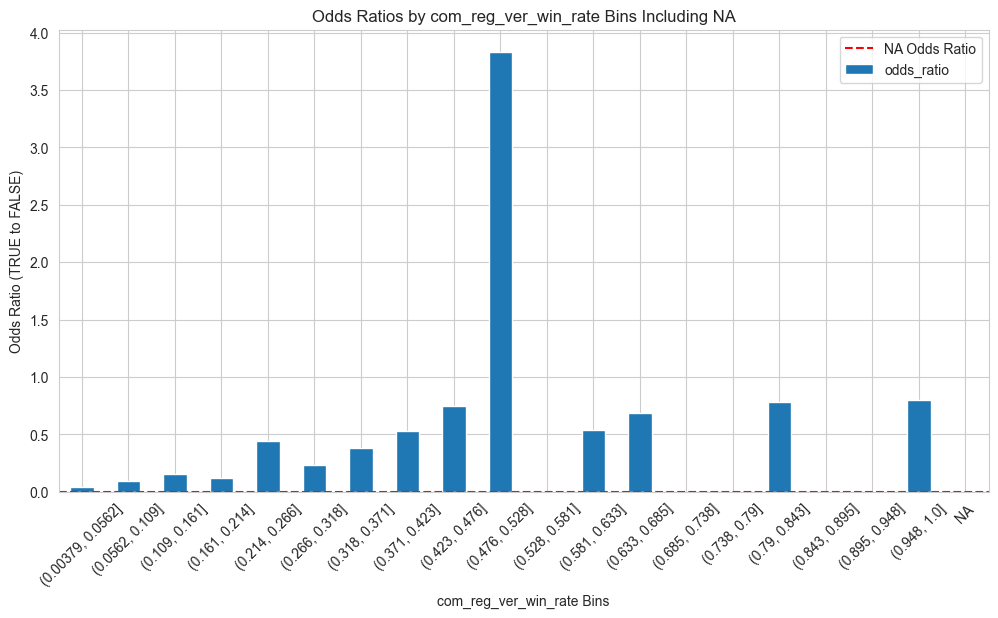

In [57]:
#impute한 후

# Separate groups
na_group = df[df['com_reg_ver_win_rate'].isna()]
non_na_group = df[~df['com_reg_ver_win_rate'].isna()]

# Calculate odds ratio for NA group
odds_ratio_na = na_group['is_converted'].value_counts(normalize=True).get('TRUE', 0) / \
                na_group['is_converted'].value_counts(normalize=True).get('FALSE', 1)

# Display the odds ratio for NA values
print(f"Odds Ratio for NA values in 'com_reg_ver_win_rate': {odds_ratio_na}")

# Bin 'com_reg_ver_win_rate' for non-NA values
bins = np.linspace(non_na_group['com_reg_ver_win_rate'].min(), non_na_group['com_reg_ver_win_rate'].max(), 20)
non_na_group['binned'] = pd.cut(non_na_group['com_reg_ver_win_rate'], bins=bins)

# Calculate odds ratio for each bin
binned_odds_ratios = non_na_group.groupby('binned')['is_converted'].value_counts(normalize=True).unstack().fillna(0)
binned_odds_ratios['odds_ratio'] = binned_odds_ratios['TRUE'] / binned_odds_ratios['FALSE']

# Find the bin with odds ratio closest to that of NA values
closest_bin = binned_odds_ratios.iloc[(binned_odds_ratios['odds_ratio'] - odds_ratio_na).abs().argsort()[:1]]

# Add NA odds ratio to the binned odds ratios for visualization
binned_odds_ratios.loc['NA', 'odds_ratio'] = odds_ratio_na

plt.figure(figsize=(12, 6))
binned_odds_ratios['odds_ratio'].plot(kind='bar')
plt.axhline(y=odds_ratio_na, color='r', linestyle='--', label='NA Odds Ratio')
plt.xlabel('com_reg_ver_win_rate Bins')
plt.ylabel('Odds Ratio (TRUE to FALSE)')
plt.title('Odds Ratios by com_reg_ver_win_rate Bins Including NA')
plt.legend()
plt.xticks(rotation=45)
plt.show()

### 3-2 customer_type

In [58]:
df['customer_type'] = df['customer_type'].fillna('Unknown')
print(len(df.customer_type.unique()))
print(df.customer_type.value_counts())
print(df.customer_type.unique())

34
customer_type
Unknown                         41358
End-Customer                     6552
End Customer                     3546
Specifier/ Influencer            2328
Channel Partner                  1282
Service Partner                   316
Solution Eco-Partner              128
Installer/Contractor               42
Specifier / Influencer             38
Corporate                          28
Engineer                           18
HVAC Engineer                      17
Technician                         16
Consultant                         15
Developer                          14
Other                              10
Software/Solution Provider          7
End-user                            7
Manager / Director                  7
Home Owner                          6
Etc.                                6
Architect/Consultant                5
Homeowner                           5
Installer                           5
Interior Designer                   5
Distributor                      

In [59]:
# Replace the specified 'expected_timeline' values
df['customer_type'] = df['customer_type'].replace({
    'End-Customer': 'End Customer',
    'Specifier/ Influencer': 'Specifier / Influencer',
    'End-user': 'End Customer',
    'Homeowner': 'End Customer',
    'Home Owner' : 'End Customer',
    'Software/Solution Provider' : 'Software / Solution Provider',
    'Installer':'Installer/Contractor',
    'Commercial end-user':'End Customer',
    'Dealer/Distributor':'Distributor'
})

# Optional: Check the updated value counts to confirm the merges
updated_counts = df['customer_type'].value_counts()
print(len(updated_counts))
print(updated_counts)

25
customer_type
Unknown                         41358
End Customer                    10117
Specifier / Influencer           2366
Channel Partner                  1282
Service Partner                   316
Solution Eco-Partner              128
Installer/Contractor               47
Corporate                          28
Engineer                           18
HVAC Engineer                      17
Technician                         16
Consultant                         15
Developer                          14
Other                              10
Software / Solution Provider        8
Manager / Director                  7
Distributor                         6
Etc.                                6
Interior Designer                   5
Architect/Consultant                5
Others                              4
Reseller                            4
Technical Assistant                 1
System Integrator                   1
Administrator                       1
Name: count, dtype: int64


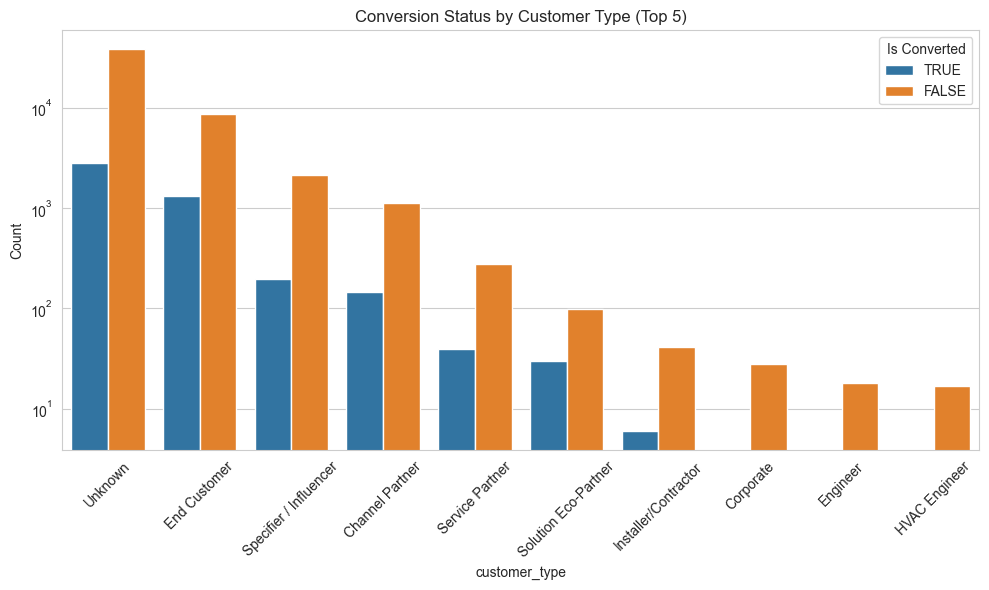

In [60]:
#compare the values of two columns by printing the columns
df.customer_type.value_counts()

top_5_customer_types = df['customer_type'].value_counts().nlargest(10).index

# Filter the DataFrame to keep only rows with the top 5 'customer_type' values
df_top_5_customer_types = df[df['customer_type'].isin(top_5_customer_types)]

# Create a count plot for the filtered DataFrame
plt.figure(figsize=(10, 6))
sns.countplot(data=df_top_5_customer_types, x='customer_type', hue='is_converted', 
              order=df_top_5_customer_types['customer_type'].value_counts().index)

plt.xticks(rotation=45)  # Rotate the x-axis labels for better readability
plt.xlabel('customer_type')
plt.ylabel('Count')
plt.title('Conversion Status by Customer Type (Top 5)')
plt.legend(title='Is Converted', loc='upper right')

plt.yscale('log')

plt.tight_layout()  # Adjust layout to make sure everything fits without overlapping
plt.show()

Odds Ratio for NA values in 'customer_type': 0.0


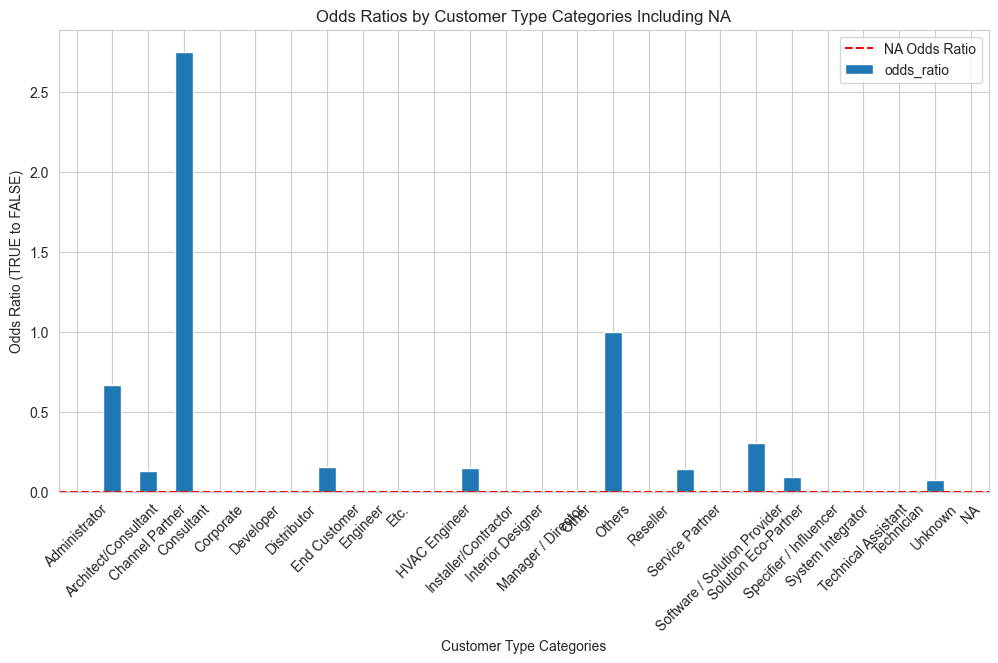

In [61]:
# Separate groups
na_group = df[df['customer_type'].isna()]
non_na_group = df[~df['customer_type'].isna()]

# Calculate odds ratio for NA group
odds_ratio_na = na_group['is_converted'].value_counts(normalize=True).get('TRUE', 0) / \
                na_group['is_converted'].value_counts(normalize=True).get('FALSE', 1)

# Display the odds ratio for NA values
print(f"Odds Ratio for NA values in 'customer_type': {odds_ratio_na}")

# Calculate odds ratio for each category in 'customer_type'
category_odds_ratios = non_na_group.groupby('customer_type')['is_converted'].value_counts(normalize=True).unstack().fillna(0)
category_odds_ratios['odds_ratio'] = category_odds_ratios['TRUE'] / category_odds_ratios['FALSE']

# Find the category with odds ratio closest to that of NA values
closest_category = category_odds_ratios.iloc[(category_odds_ratios['odds_ratio'] - odds_ratio_na).abs().argsort()[:1]]

# Add NA odds ratio to the category odds ratios for visualization
category_odds_ratios.loc['NA', 'odds_ratio'] = odds_ratio_na

plt.figure(figsize=(12, 6))
category_odds_ratios['odds_ratio'].plot(kind='bar')
plt.axhline(y=odds_ratio_na, color='r', linestyle='--', label='NA Odds Ratio')
plt.xlabel('Customer Type Categories')
plt.ylabel('Odds Ratio (TRUE to FALSE)')
plt.title('Odds Ratios by Customer Type Categories Including NA')
plt.legend()
plt.xticks(rotation=45)
plt.show()

### 3-3 historical_existing_cnt

In [62]:
#도메인 지식으로는, 이 데이터가 회사에서 온것이므로, 회사가 단 한번이라도 고객을 상대했더라면 그 기록이 남았을것이다. 
# 따라서 이 칼럼의 NA는 전적이 없다, 즉 0으로 채울 수 있다. Domain Knowledge에 의한 imputation

# df = df.drop(columns=['historical_existing_cnt'])

df.historical_existing_cnt.fillna(0, inplace=True)
df.historical_existing_cnt.unique()

array([0.000e+00, 1.200e+01, 1.440e+02, 3.000e+00, 2.300e+01, 4.700e+01,
       1.000e+00, 1.900e+01, 4.200e+01, 7.500e+01, 1.700e+01, 2.000e+01,
       5.000e+00, 2.000e+00, 1.150e+02, 4.000e+00, 1.600e+01, 6.000e+00,
       3.100e+01, 4.900e+01, 1.000e+01, 1.100e+01, 4.000e+01, 7.000e+00,
       6.100e+01, 4.500e+01, 5.700e+01, 1.750e+02, 1.300e+01, 9.900e+01,
       1.500e+01, 8.000e+00, 2.100e+01, 5.600e+01, 6.660e+02, 1.220e+02,
       3.240e+02, 2.200e+01, 8.000e+01, 3.600e+01, 2.800e+01, 1.720e+02,
       6.600e+01, 3.200e+01, 5.300e+01, 3.800e+01, 1.890e+02, 5.800e+01,
       2.700e+01, 1.060e+02, 1.680e+02, 9.000e+00, 4.600e+01, 4.800e+01,
       5.200e+01, 7.300e+01, 9.200e+01, 6.000e+01, 3.900e+01, 1.800e+01,
       1.400e+01, 2.120e+02, 4.720e+02, 3.900e+02, 6.900e+01, 2.330e+02,
       2.900e+01, 3.000e+01, 2.400e+01, 7.800e+01, 1.070e+02, 4.100e+01,
       1.660e+02, 5.900e+01, 4.400e+01, 1.140e+02, 3.700e+01, 3.500e+01,
       1.580e+02, 8.500e+01, 7.700e+01, 2.600e+01, 

Odds Ratio for NA values in 'historical_existing_cnt': 0.0


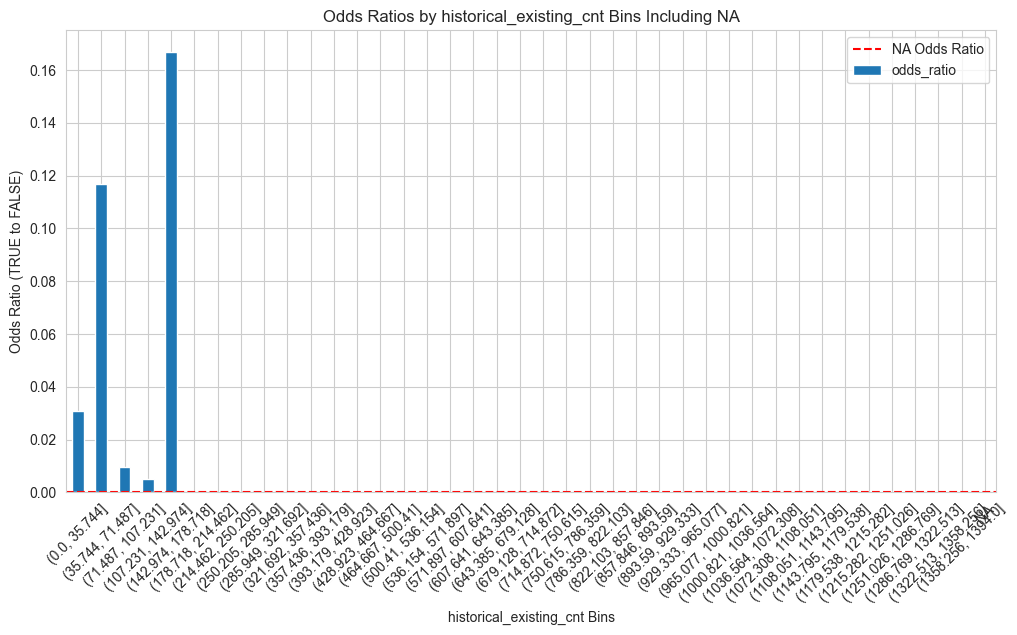

In [63]:
# Separate groups
na_group = df[df['historical_existing_cnt'].isna()]
non_na_group = df[~df['historical_existing_cnt'].isna()]

# Calculate odds ratio for NA group
odds_ratio_na = na_group['is_converted'].value_counts(normalize=True).get('TRUE', 0) / \
                na_group['is_converted'].value_counts(normalize=True).get('FALSE', 1)

# Display the odds ratio for NA values
print(f"Odds Ratio for NA values in 'historical_existing_cnt': {odds_ratio_na}")

# Bin 'com_reg_ver_win_rate' for non-NA values
bins = np.linspace(non_na_group['historical_existing_cnt'].min(), non_na_group['historical_existing_cnt'].max(), 40)
non_na_group['binned'] = pd.cut(non_na_group['historical_existing_cnt'], bins=bins)

# Calculate odds ratio for each bin
binned_odds_ratios = non_na_group.groupby('binned')['is_converted'].value_counts(normalize=True).unstack().fillna(0)
binned_odds_ratios['odds_ratio'] = binned_odds_ratios['TRUE'] / binned_odds_ratios['FALSE']

# Find the bin with odds ratio closest to that of NA values
closest_bin = binned_odds_ratios.iloc[(binned_odds_ratios['odds_ratio'] - odds_ratio_na).abs().argsort()[:1]]

# Add NA odds ratio to the binned odds ratios for visualization
binned_odds_ratios.loc['NA', 'odds_ratio'] = odds_ratio_na

plt.figure(figsize=(12, 6))
binned_odds_ratios['odds_ratio'].plot(kind='bar')
plt.axhline(y=odds_ratio_na, color='r', linestyle='--', label='NA Odds Ratio')
plt.xlabel('historical_existing_cnt Bins')
plt.ylabel('Odds Ratio (TRUE to FALSE)')
plt.title('Odds Ratios by historical_existing_cnt Bins Including NA')
plt.legend()
plt.xticks(rotation=45)
plt.show()

### 3-4 product subcategory

In [64]:
for col in df.columns:
    if df[col].isnull().sum()/len(df)*100 > 50:
        print(col, df[col].isnull().sum()/len(df)*100)

product_subcategory 83.85442811043384
product_modelname 83.80960917891717
expected_timeline 50.72068841878809
ver_win_rate_x 68.11222660451774
ver_win_ratio_per_bu 73.31660093223378
business_area 68.11222660451774


In [65]:
df['product_subcategory'].isna().sum()

46774

In [66]:
# product subcategory를 알아왔다 한다는것 자체만으로도 고객이 상품에 관심이 있다는것을 의미한다. 고로 null 값은 답을 주지 않았다는 것이므로 NA로 채워준다.

# Replace the values in 'product_subcategory' column
df['product_subcategory'] = df['product_subcategory'].apply(lambda x: 'NA' if pd.isnull(x) or x == 'NA' else 'Filled')

# Verify the changes
print(df['product_subcategory'].value_counts())

product_subcategory
NA        46774
Filled     9006
Name: count, dtype: int64


In [67]:
print(len(df['product_subcategory'].unique()))
print(df['product_subcategory'].value_counts())
df['product_subcategory'].unique()

2
product_subcategory
NA        46774
Filled     9006
Name: count, dtype: int64


array(['NA', 'Filled'], dtype=object)

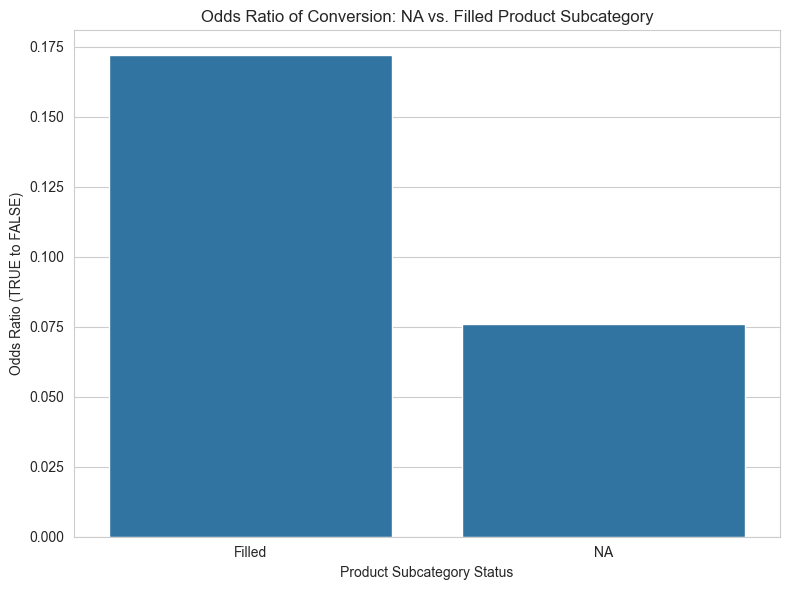

In [68]:
# Assuming df is your DataFrame

# Calculate odds ratio for 'NA' and 'Filled' groups in 'product_subcategory'
odds_ratio = df.groupby('product_subcategory')['is_converted'].value_counts(normalize=True).unstack().fillna(0)
odds_ratio['Odds Ratio'] = odds_ratio['TRUE'] / odds_ratio['FALSE']

# Reset the index to use in seaborn barplot
odds_ratios_subcategory = odds_ratio.reset_index()[['product_subcategory', 'Odds Ratio']]

plt.figure(figsize=(8, 6))
sns.barplot(data=odds_ratios_subcategory, x='product_subcategory', y='Odds Ratio')
plt.xlabel('Product Subcategory Status')
plt.ylabel('Odds Ratio (TRUE to FALSE)')
plt.title('Odds Ratio of Conversion: NA vs. Filled Product Subcategory')
plt.tight_layout()
plt.show()

In [69]:
# # 최고 10개만 거르는 코드
# top_10_subcategories = df['product_subcategory'].value_counts().nlargest(20).index
# df['product_subcategory'] = df['product_subcategory'].apply(lambda x: x if x in top_10_subcategories else 'Others')

# # Separate groups
# na_group = df[df['product_subcategory'].isna()]
# non_na_group = df[~df['product_subcategory'].isna()]

# # Calculate odds ratio for NA group
# odds_ratio_na = na_group['is_converted'].value_counts(normalize=True).get('TRUE', 0) / \
#                 na_group['is_converted'].value_counts(normalize=True).get('FALSE', 1)

# # Display the odds ratio for NA values
# print(f"Odds Ratio for NA values in 'product_subcategory': {odds_ratio_na}")

# # Calculate odds ratio for each category in 'customer_type'
# category_odds_ratios = non_na_group.groupby('product_subcategory')['is_converted'].value_counts(normalize=True).unstack().fillna(0)
# category_odds_ratios['odds_ratio'] = category_odds_ratios['TRUE'] / category_odds_ratios['FALSE']

# # Find the category with odds ratio closest to that of NA values
# closest_category = category_odds_ratios.iloc[(category_odds_ratios['odds_ratio'] - odds_ratio_na).abs().argsort()[:1]]

# # Add NA odds ratio to the category odds ratios for visualization
# category_odds_ratios.loc['NA', 'odds_ratio'] = odds_ratio_na

# plt.figure(figsize=(12, 6))
# category_odds_ratios['odds_ratio'].plot(kind='bar')
# plt.axhline(y=odds_ratio_na, color='r', linestyle='--', label='NA Odds Ratio')
# plt.xlabel('product_subcategory Categories')
# plt.ylabel('Odds Ratio (TRUE to FALSE)')
# plt.title('Odds Ratios by product_subcategory Categories Including NA')
# plt.legend()
# plt.xticks(rotation=45)
# plt.show()

### 3-5 product_modelname

In [70]:
# product modelname을 알아왔다 한다는것 자체만으로도 고객이 상품에 관심이 있다는것을 의미한다. 고로 null 값은 답을 주지 않았다는 것이므로 NA로 채워준다.

# Replace the values in 'product_modelname' column
df['product_modelname'] = df['product_modelname'].apply(lambda x: 'NA' if pd.isnull(x) or x == 'NA' else 'Filled')

# Verify the changes
print(df['product_modelname'].value_counts())

product_modelname
NA        46749
Filled     9031
Name: count, dtype: int64


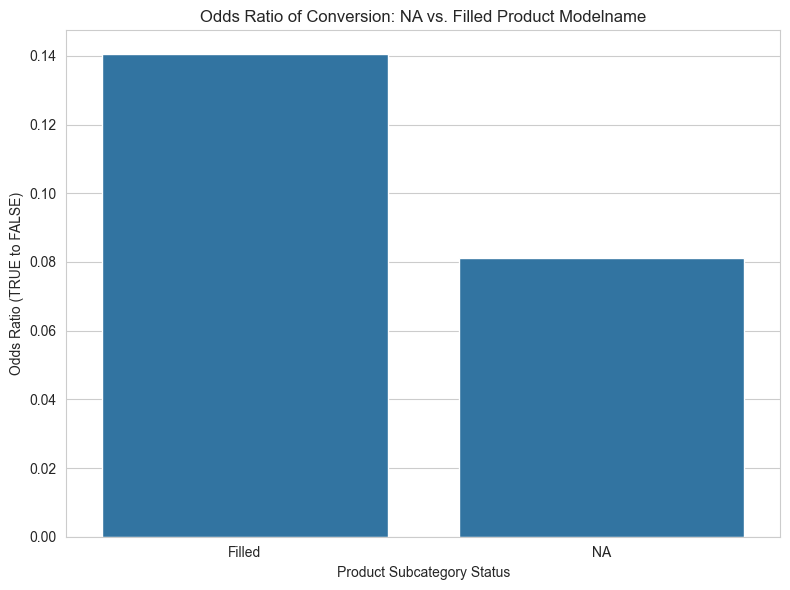

In [71]:
# Calculate odds ratio for 'NA' and 'Filled' groups in 'product_subcategory'
odds_ratio = df.groupby('product_modelname')['is_converted'].value_counts(normalize=True).unstack().fillna(0)
odds_ratio['Odds Ratio'] = odds_ratio['TRUE'] / odds_ratio['FALSE']

# Reset the index to use in seaborn barplot
odds_ratios_subcategory = odds_ratio.reset_index()[['product_modelname', 'Odds Ratio']]

plt.figure(figsize=(8, 6))
sns.barplot(data=odds_ratios_subcategory, x='product_modelname', y='Odds Ratio')
plt.xlabel('Product Subcategory Status')
plt.ylabel('Odds Ratio (TRUE to FALSE)')
plt.title('Odds Ratio of Conversion: NA vs. Filled Product Modelname')
plt.tight_layout()
plt.show()

### 3-6 expected_timeline

In [72]:
print(len(df['expected_timeline'].unique()))
print(df['expected_timeline'].value_counts())
df['expected_timeline'].unique()

450
expected_timeline
less than 3 months                                                                                                            16768
3 months ~ 6 months                                                                                                            4798
more than a year                                                                                                               2874
9 months ~ 1 year                                                                                                              1070
6 months ~ 9 months                                                                                                            1043
                                                                                                                              ...  
no requirement of this time                                                                                                       1
not reachable , lead shared with partner              

array(['less than 3 months', nan, '3 months ~ 6 months',
       '9 months ~ 1 year', 'more than a year', '6 months ~ 9 months',
       'quote has been sent to customer.',
       'partner was exploring on eol model for some requiremeent. no designated sales or closure expected hence closing in the system.',
       'already close in july purchse with rd',
       'client not interested in product.. receing call and not answering properly',
       'being followed up', 'being followed up.',
       'repeated inquiry from client. he was just inquiring but have not confimred on purchase. we have tried mulitple times but client is not interested in buying.',
       'update- 7th aug--demo given. customer will confirm next week',
       "tried to reach him multipe times from last 7 days but couldn't get through",
       'details send', 'discused with ankit in dehli',
       'requires detail for tender. no purchase requirement right now.',
       'partner is into static signages. he need to connec

In [78]:
value_counts = df['expected_timeline'].value_counts()

# Filter for unique values with a count of more than 50
filtered_value_counts = value_counts[value_counts > 3]

# Display the filtered unique values and their counts
print(filtered_value_counts)

expected_timeline
less than 3 months     16843
3 months ~ 6 months     4915
more than a year        2878
9 months ~ 1 year       1076
6 months ~ 9 months     1047
being followed up        110
etc.                     100
no requirement            51
no time information       13
Name: count, dtype: int64


In [77]:
# Replace the specified 'expected_timeline' values
df['expected_timeline'] = df['expected_timeline'].replace({
    'less_than_3_months': 'less than 3 months',  # merge into 'less than 3 months'
    'being followed up.': 'being followed up',  # merge into 'being followed up.'
    'forwarded to bdo, being followed up':'being followed up',
    'less than 6 months': '3 months ~ 6 months',  # merge into '3 months ~ 6 months'
    '3_months_~_6_months' : '3 months ~ 6 months',
    '9_months_~_1_year':'9 months ~ 1 year',
    '6_months_~_9_months':'6 months ~ 9 months',
    'more_than_a_year':'more than a year',
    'not answering call':'no time information',
    'couldn\'t connect':'no time information',
    'didn\'t respond':'no requirement',
    'budget issue':'no time information',
    'the client is not having any requirement hence closig in system. although the details of idb are mailed to client.':'no requirement',
    'duplicate lead':'no requirement',
    'rnr':'etc.',
    'details send':'being followed up',
    'quote send':'being followed up',
    'details shared':'being followed up',
    'the client is not having any requirement, he was only browsing through the produt hence closig in system. although the details of idb are mailed to client.':'no requirement'
})

# Optional: Check the updated value counts to confirm the merges
updated_counts = df['expected_timeline'].value_counts()
print(updated_counts)

expected_timeline
less than 3 months                                                                                                            16843
3 months ~ 6 months                                                                                                            4915
more than a year                                                                                                               2878
9 months ~ 1 year                                                                                                              1076
6 months ~ 9 months                                                                                                            1047
                                                                                                                              ...  
not reachable , lead shared with partner                                                                                          1
discussed with client. details mailed to client. no budget

In [81]:
top_expected_timelines = df['expected_timeline'].value_counts().nlargest(9).index

# Replace all other 'expected_timeline' values with 'Others'
df['expected_timeline'] = df['expected_timeline'].apply(lambda x: x if x in top_expected_timelines else 'etc.')


expected_timeline
Others                 28760
less than 3 months     16843
3 months ~ 6 months     4915
more than a year        2878
9 months ~ 1 year       1076
6 months ~ 9 months     1047
being followed up        110
etc.                     100
no requirement            51
Name: count, dtype: int64


In [83]:
df['expected_timeline'] = df['expected_timeline'].fillna('Unknown')
value_counts = df['expected_timeline'].value_counts()

# Filter for unique values with a count of more than 50
filtered_value_counts = value_counts[value_counts > 3]

# Display the filtered unique values and their counts
print(filtered_value_counts)

expected_timeline
Others                 28760
less than 3 months     16843
3 months ~ 6 months     4915
more than a year        2878
9 months ~ 1 year       1076
6 months ~ 9 months     1047
being followed up        110
etc.                     100
no requirement            51
Name: count, dtype: int64


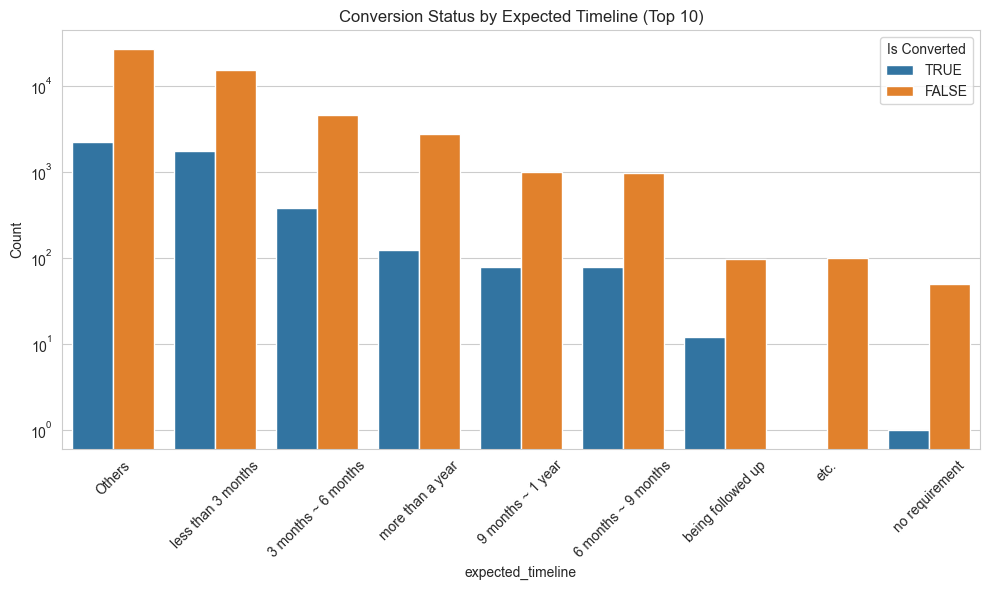

In [86]:
#compare the values of two columns by printing the columns
df.customer_type.value_counts()

top_5_customer_types = df['expected_timeline'].value_counts().nlargest(10).index

# Filter the DataFrame to keep only rows with the top 5 'customer_type' values
df_top_5_customer_types = df[df['expected_timeline'].isin(top_5_customer_types)]

# Create a count plot for the filtered DataFrame
plt.figure(figsize=(10, 6))
sns.countplot(data=df_top_5_customer_types, x='expected_timeline', hue='is_converted', 
              order=df_top_5_customer_types['expected_timeline'].value_counts().index)

plt.xticks(rotation=45)  # Rotate the x-axis labels for better readability
plt.xlabel('expected_timeline')
plt.ylabel('Count')
plt.title('Conversion Status by Expected Timeline (Top 10)')
plt.legend(title='Is Converted', loc='upper right')

plt.yscale('log')

plt.tight_layout()  # Adjust layout to make sure everything fits without overlapping
plt.show()

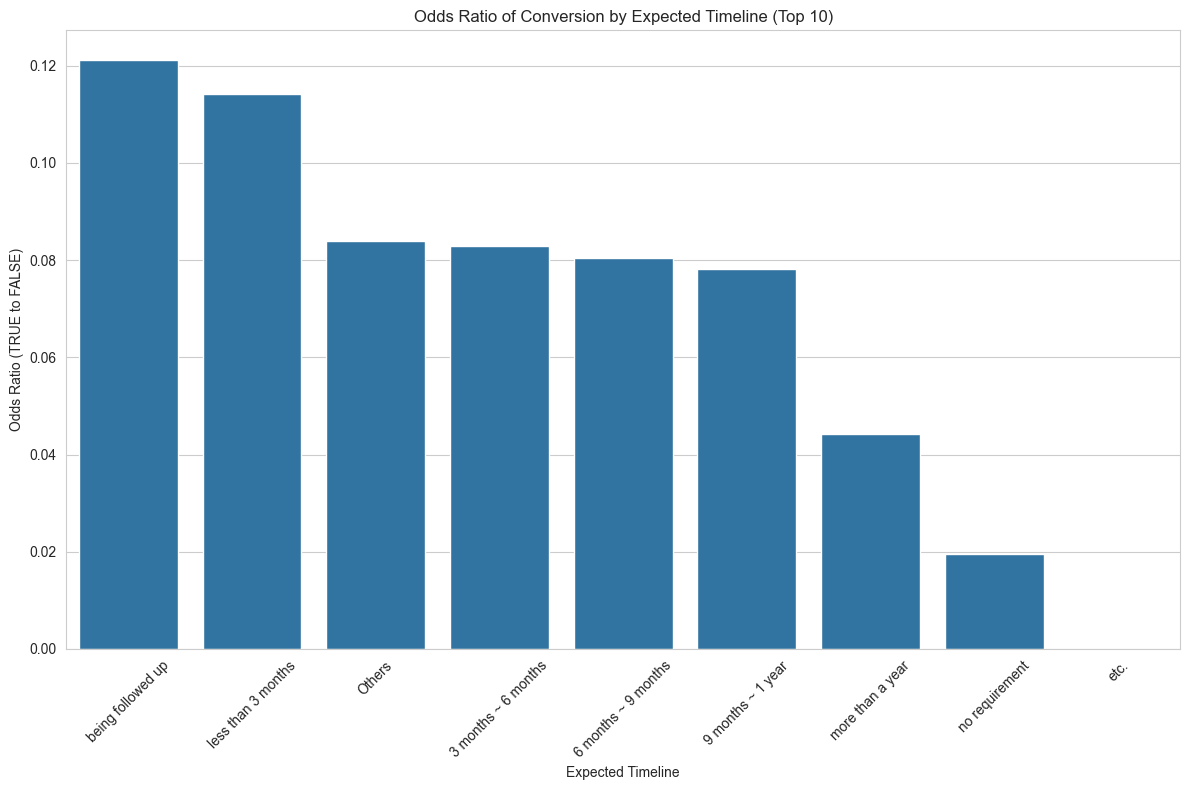

In [88]:
def calculate_odds_ratio(group):
    converted = group[group['is_converted'] == 'TRUE'].shape[0]
    not_converted = group[group['is_converted'] == 'FALSE'].shape[0]
    odds_ratio = (converted / (not_converted + 1))  # Adding 1 to avoid division by zero
    return odds_ratio

odds_ratios = df.groupby('expected_timeline').apply(calculate_odds_ratio)

# Filter to keep only the top 10 'expected_timeline' based on the odds ratio
top_10_odds_ratios = odds_ratios.nlargest(10)

# Create a DataFrame for visualization
odds_ratio_df = pd.DataFrame({'expected_timeline': top_10_odds_ratios.index, 'Odds Ratio': top_10_odds_ratios.values})

plt.figure(figsize=(12, 8))
sns.barplot(data=odds_ratio_df, x='expected_timeline', y='Odds Ratio')
plt.xticks(rotation=45)  # Rotate the x-axis labels for better readability
plt.xlabel('Expected Timeline')
plt.ylabel('Odds Ratio (TRUE to FALSE)')
plt.title('Odds Ratio of Conversion by Expected Timeline (Top 10)')
plt.tight_layout()  # Adjust layout to make sure everything fits without overlapping
plt.show()

In [10]:
df.drop(columns='expected_timeline', inplace=True, axis=1)
df.columns

KeyError: "['expected_timeline'] not found in axis"

### 3-7 ver_win_rate_x

Odds Ratio for NA values in 'ver_win_rate_x': 0.0968272756141921


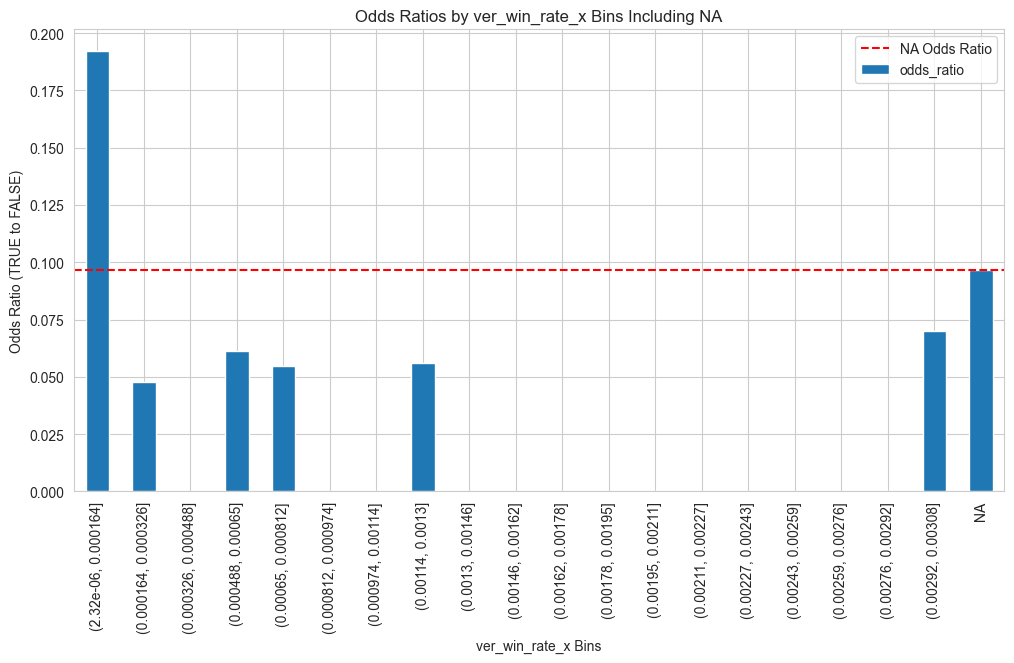

In [11]:
# Separate groups
na_group = df[df['ver_win_rate_x'].isna()]
non_na_group = df[~df['ver_win_rate_x'].isna()]

# Calculate odds ratio for NA group
odds_ratio_na = na_group['is_converted'].value_counts(normalize=True).get('TRUE', 0) / \
                na_group['is_converted'].value_counts(normalize=True).get('FALSE', 1)

# Display the odds ratio for NA values
print(f"Odds Ratio for NA values in 'ver_win_rate_x': {odds_ratio_na}")

# Bin 'com_reg_ver_win_rate' for non-NA values
bins = np.linspace(non_na_group['ver_win_rate_x'].min(), non_na_group['ver_win_rate_x'].max(), 20)
non_na_group['binned'] = pd.cut(non_na_group['ver_win_rate_x'], bins=bins)

# Calculate odds ratio for each bin
binned_odds_ratios = non_na_group.groupby('binned')['is_converted'].value_counts(normalize=True).unstack().fillna(0)
binned_odds_ratios['odds_ratio'] = binned_odds_ratios['TRUE'] / binned_odds_ratios['FALSE']

# Find the bin with odds ratio closest to that of NA values
closest_bin = binned_odds_ratios.iloc[(binned_odds_ratios['odds_ratio'] - odds_ratio_na).abs().argsort()[:1]]

# Add NA odds ratio to the binned odds ratios for visualization
binned_odds_ratios.loc['NA', 'odds_ratio'] = odds_ratio_na

plt.figure(figsize=(12, 6))
binned_odds_ratios['odds_ratio'].plot(kind='bar')
plt.axhline(y=odds_ratio_na, color='r', linestyle='--', label='NA Odds Ratio')
plt.xlabel('ver_win_rate_x Bins')
plt.ylabel('Odds Ratio (TRUE to FALSE)')
plt.title('Odds Ratios by ver_win_rate_x Bins Including NA')
plt.legend()
plt.xticks(rotation=90)
plt.show()

In [12]:
from sklearn.impute import KNNImputer

# Initialize the KNN Imputer with default parameters (you can choose to modify these)
imputer = KNNImputer(n_neighbors=5)

# It's important to note that KNNImputer works with numerical data, so we need to ensure that 'ver_win_rate_x' is of a numerical type
# Let's first ensure the column is of a numerical type, converting it if necessary
df['ver_win_rate_x'] = pd.to_numeric(df['ver_win_rate_x'], errors='coerce')

# Apply the imputer to the DataFrame
# df_imputed = df.copy()
# df_imputed['ver_win_rate_x'] = imputer.fit_transform(df[['ver_win_rate_x']])
df['ver_win_rate_x'] = imputer.fit_transform(df[['ver_win_rate_x']])
# Check the first few entries of the column to verify imputation
# df_imputed['ver_win_rate_x'].head()
df['ver_win_rate_x'].head()

0    0.003079
1    0.003079
2    0.003079
3    0.003079
4    0.003079
Name: ver_win_rate_x, dtype: float64

Odds Ratio for NA values in 'ver_win_rate_x': 0.0


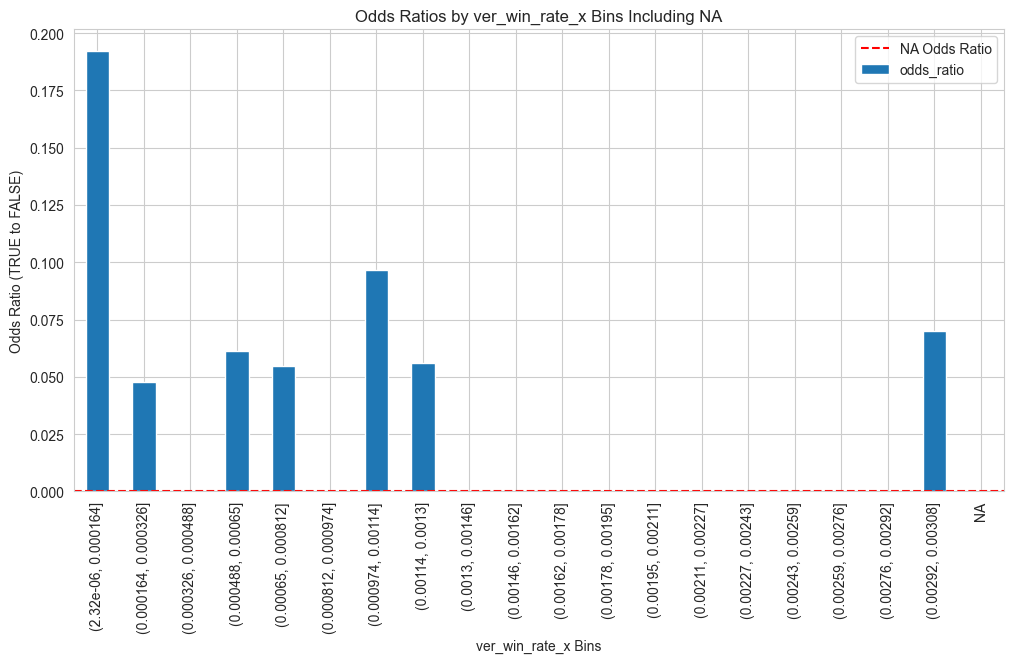

In [13]:
# Separate groups
na_group = df[df['ver_win_rate_x'].isna()]
non_na_group = df[~df['ver_win_rate_x'].isna()]

# Calculate odds ratio for NA group
odds_ratio_na = na_group['is_converted'].value_counts(normalize=True).get('TRUE', 0) / \
                na_group['is_converted'].value_counts(normalize=True).get('FALSE', 1)

# Display the odds ratio for NA values
print(f"Odds Ratio for NA values in 'ver_win_rate_x': {odds_ratio_na}")

# Bin 'com_reg_ver_win_rate' for non-NA values
bins = np.linspace(non_na_group['ver_win_rate_x'].min(), non_na_group['ver_win_rate_x'].max(), 20)
non_na_group['binned'] = pd.cut(non_na_group['ver_win_rate_x'], bins=bins)

# Calculate odds ratio for each bin
binned_odds_ratios = non_na_group.groupby('binned')['is_converted'].value_counts(normalize=True).unstack().fillna(0)
binned_odds_ratios['odds_ratio'] = binned_odds_ratios['TRUE'] / binned_odds_ratios['FALSE']

# Find the bin with odds ratio closest to that of NA values
closest_bin = binned_odds_ratios.iloc[(binned_odds_ratios['odds_ratio'] - odds_ratio_na).abs().argsort()[:1]]

# Add NA odds ratio to the binned odds ratios for visualization
binned_odds_ratios.loc['NA', 'odds_ratio'] = odds_ratio_na

plt.figure(figsize=(12, 6))
binned_odds_ratios['odds_ratio'].plot(kind='bar')
plt.axhline(y=odds_ratio_na, color='r', linestyle='--', label='NA Odds Ratio')
plt.xlabel('ver_win_rate_x Bins')
plt.ylabel('Odds Ratio (TRUE to FALSE)')
plt.title('Odds Ratios by ver_win_rate_x Bins Including NA')
plt.legend()
plt.xticks(rotation=90)
plt.show()

### 3-8 ver_win_ratio_per_bu

Odds Ratio for NA values in 'ver_win_ratio_per_bu': 0.09947306161952899


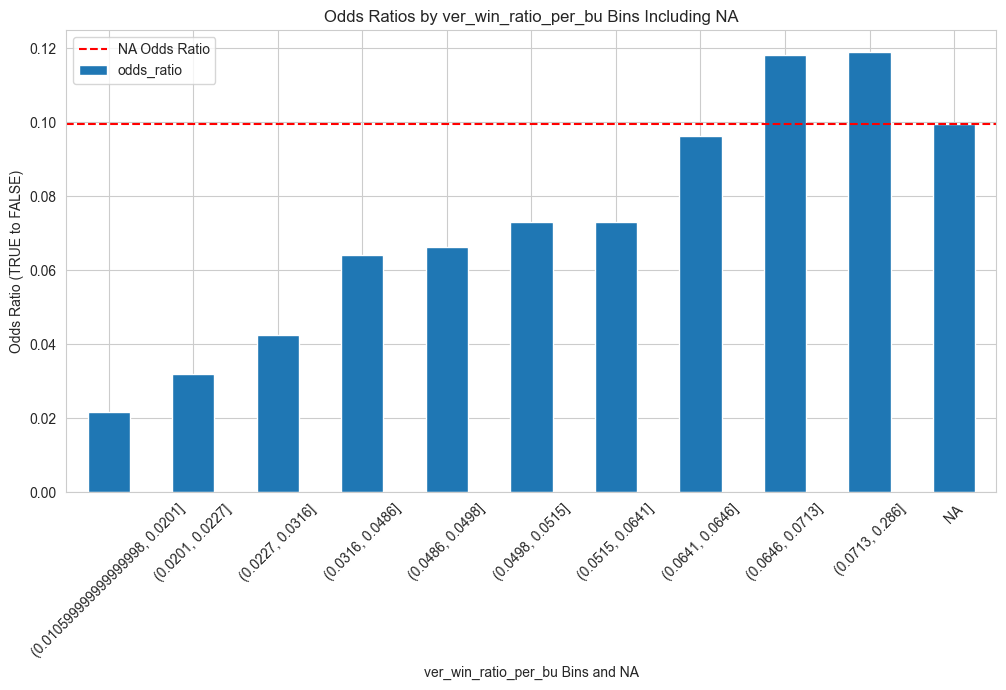

In [14]:
# Calculate odds ratio for NA group in 'ver_win_ratio_per_bu'
na_group_ver_bu = df[df['ver_win_ratio_per_bu'].isna()]
odds_ratio_na_ver_bu = na_group_ver_bu['is_converted'].value_counts(normalize=True).get('TRUE', 0) / \
                na_group_ver_bu['is_converted'].value_counts(normalize=True).get('FALSE', 1)

print(f"Odds Ratio for NA values in 'ver_win_ratio_per_bu': {odds_ratio_na_ver_bu}")

# Working with the non-NA subset for 'ver_win_ratio_per_bu'
non_na_group_ver_bu = df.dropna(subset=['ver_win_ratio_per_bu'])

# Bin 'ver_win_ratio_per_bu' into quantiles for fair distribution
non_na_group_ver_bu['ver_win_ratio_per_bu_binned'] = pd.qcut(non_na_group_ver_bu['ver_win_ratio_per_bu'], q=10, duplicates='drop')

# Calculate odds ratio for each bin
binned_odds_ratios_ver_bu = non_na_group_ver_bu.groupby('ver_win_ratio_per_bu_binned')['is_converted'].value_counts(normalize=True).unstack().fillna(0)
binned_odds_ratios_ver_bu['odds_ratio'] = binned_odds_ratios_ver_bu['TRUE'] / binned_odds_ratios_ver_bu['FALSE']

# Find bin with odds ratio closest to that of NA values
closest_bin_ver_bu = binned_odds_ratios_ver_bu.iloc[(binned_odds_ratios_ver_bu['odds_ratio'] - odds_ratio_na_ver_bu).abs().argsort()[:1]]

# Visualization
plt.figure(figsize=(12, 6))

# Convert index to string for consistent handling and visualization
binned_odds_ratios_ver_bu.index = binned_odds_ratios_ver_bu.index.astype(str)

# Now adding 'NA' as a string should not cause sorting issues
binned_odds_ratios_ver_bu.loc['NA', 'odds_ratio'] = odds_ratio_na_ver_bu

# Sort index alphabetically, which now includes 'NA' as a comparable string type
binned_odds_ratios_ver_bu = binned_odds_ratios_ver_bu.sort_index()

binned_odds_ratios_ver_bu['odds_ratio'].plot(kind='bar')
plt.axhline(y=odds_ratio_na_ver_bu, color='r', linestyle='--', label='NA Odds Ratio')
plt.xlabel('ver_win_ratio_per_bu Bins and NA')
plt.ylabel('Odds Ratio (TRUE to FALSE)')
plt.title('Odds Ratios by ver_win_ratio_per_bu Bins Including NA')
plt.legend()
plt.xticks(rotation=45)
plt.show()

In [15]:
# # df['ver_win_ratio_per_bu'] = df['ver_win_ratio_per_bu'].fillna(0.0645)

# from sklearn.impute import KNNImputer

# # Initialize the KNN Imputer with default parameters (you can choose to modify these)
# imputer = KNNImputer(n_neighbors=5)

# # It's important to note that KNNImputer works with numerical data, so we need to ensure that 'ver_win_rate_x' is of a numerical type
# # Let's first ensure the column is of a numerical type, converting it if necessary
# df['ver_win_ratio_per_bu'] = pd.to_numeric(df['ver_win_ratio_per_bu'], errors='coerce')

# # Apply the imputer to the DataFrame
# # df_imputed = df.copy()
# # df_imputed['ver_win_rate_x'] = imputer.fit_transform(df[['ver_win_rate_x']])
# df['ver_win_ratio_per_bu'] = imputer.fit_transform(df[['ver_win_ratio_per_bu']])
# # Check the first few entries of the column to verify imputation
# # df_imputed['ver_win_rate_x'].head()
# df['ver_win_ratio_per_bu'].head()

0    0.026846
1    0.026846
2    0.026846
3    0.026846
4    0.026846
Name: ver_win_ratio_per_bu, dtype: float64

Odds Ratio for NA values in 'ver_win_ratio_per_bu': 0.0


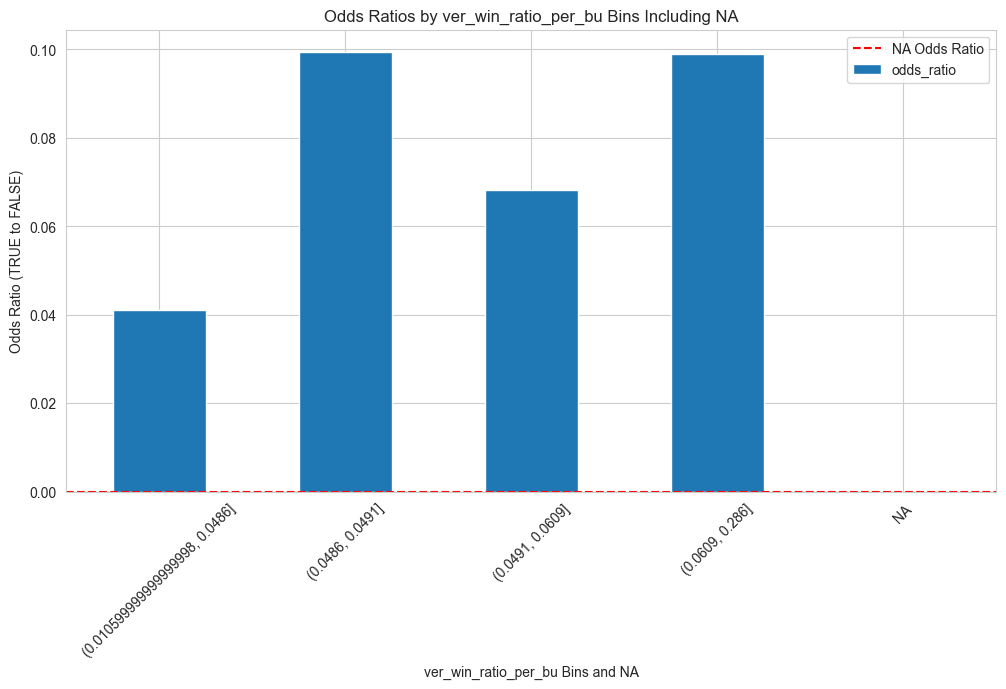

In [16]:
# # Calculate odds ratio for NA group in 'ver_win_ratio_per_bu'
# na_group_ver_bu = df[df['ver_win_ratio_per_bu'].isna()]
# odds_ratio_na_ver_bu = na_group_ver_bu['is_converted'].value_counts(normalize=True).get('TRUE', 0) / \
#                 na_group_ver_bu['is_converted'].value_counts(normalize=True).get('FALSE', 1)

# print(f"Odds Ratio for NA values in 'ver_win_ratio_per_bu': {odds_ratio_na_ver_bu}")

# # Working with the non-NA subset for 'ver_win_ratio_per_bu'
# non_na_group_ver_bu = df.dropna(subset=['ver_win_ratio_per_bu'])

# # Bin 'ver_win_ratio_per_bu' into quantiles for fair distribution
# non_na_group_ver_bu['ver_win_ratio_per_bu_binned'] = pd.qcut(non_na_group_ver_bu['ver_win_ratio_per_bu'], q=10, duplicates='drop')

# # Calculate odds ratio for each bin
# binned_odds_ratios_ver_bu = non_na_group_ver_bu.groupby('ver_win_ratio_per_bu_binned')['is_converted'].value_counts(normalize=True).unstack().fillna(0)
# binned_odds_ratios_ver_bu['odds_ratio'] = binned_odds_ratios_ver_bu['TRUE'] / binned_odds_ratios_ver_bu['FALSE']

# # Find bin with odds ratio closest to that of NA values
# closest_bin_ver_bu = binned_odds_ratios_ver_bu.iloc[(binned_odds_ratios_ver_bu['odds_ratio'] - odds_ratio_na_ver_bu).abs().argsort()[:1]]

# # Visualization
# plt.figure(figsize=(12, 6))

# # Convert index to string for consistent handling and visualization
# binned_odds_ratios_ver_bu.index = binned_odds_ratios_ver_bu.index.astype(str)

# # Now adding 'NA' as a string should not cause sorting issues
# binned_odds_ratios_ver_bu.loc['NA', 'odds_ratio'] = odds_ratio_na_ver_bu

# # Sort index alphabetically, which now includes 'NA' as a comparable string type
# binned_odds_ratios_ver_bu = binned_odds_ratios_ver_bu.sort_index()

# binned_odds_ratios_ver_bu['odds_ratio'].plot(kind='bar')
# plt.axhline(y=odds_ratio_na_ver_bu, color='r', linestyle='--', label='NA Odds Ratio')
# plt.xlabel('ver_win_ratio_per_bu Bins and NA')
# plt.ylabel('Odds Ratio (TRUE to FALSE)')
# plt.title('Odds Ratios by ver_win_ratio_per_bu Bins Including NA')
# plt.legend()
# plt.xticks(rotation=45)
# plt.show()

In [17]:
df.drop(columns='ver_win_ratio_per_bu', inplace=True, axis=1)
df.columns

Index(['bant_submit', 'customer_country', 'business_unit',
       'com_reg_ver_win_rate', 'customer_idx', 'customer_type', 'enterprise',
       'historical_existing_cnt', 'id_strategic_ver', 'it_strategic_ver',
       'idit_strategic_ver', 'customer_job', 'lead_desc_length',
       'inquiry_type', 'product_category', 'product_subcategory',
       'product_modelname', 'customer_country.1', 'customer_position',
       'response_corporate', 'ver_cus', 'ver_pro', 'ver_win_rate_x',
       'business_area', 'business_subarea', 'lead_owner', 'is_converted'],
      dtype='object')

### 3-9 business_area

In [20]:
print(len(df.business_area.unique()))
df.business_area.value_counts()

13


business_area
corporate / office                3989
retail                            2924
hotel & accommodation             1960
special purpose                   1873
residential (home)                1786
education                         1682
hospital & health care            1023
factory                           1013
government department              635
public facility                    502
transportation                     292
power plant / renewable energy     108
Name: count, dtype: int64

In [21]:
df['business_area'] = df['business_area'].fillna('NA')

In [159]:
# # Separate groups
# na_group = df[df['business_area'].isna()]
# non_na_group = df[~df['business_area'].isna()]

# # Calculate odds ratio for NA group
# odds_ratio_na = na_group['is_converted'].value_counts(normalize=True).get('TRUE', 0) / \
#                 na_group['is_converted'].value_counts(normalize=True).get('FALSE', 1)

# # Display the odds ratio for NA values
# print(f"Odds Ratio for NA values in 'business_area': {odds_ratio_na}")

# # Calculate odds ratio for each category in 'customer_type'
# category_odds_ratios = non_na_group.groupby('business_area')['is_converted'].value_counts(normalize=True).unstack().fillna(0)
# category_odds_ratios['odds_ratio'] = category_odds_ratios['TRUE'] / category_odds_ratios['FALSE']

# # Find the category with odds ratio closest to that of NA values
# closest_category = category_odds_ratios.iloc[(category_odds_ratios['odds_ratio'] - odds_ratio_na).abs().argsort()[:1]]

# # Add NA odds ratio to the category odds ratios for visualization
# category_odds_ratios.loc['NA', 'odds_ratio'] = odds_ratio_na

# plt.figure(figsize=(12, 6))
# category_odds_ratios['odds_ratio'].plot(kind='bar')
# plt.axhline(y=odds_ratio_na, color='r', linestyle='--', label='NA Odds Ratio')
# plt.xlabel('business_area Categories')
# plt.ylabel('Odds Ratio (TRUE to FALSE)')
# plt.title('Odds Ratios by business_area Categories Including NA')
# plt.legend()
# plt.xticks(rotation=45)
# plt.show()

## 4 NA율 50% 이하

### 4-1 customer_job

In [24]:
print(len(df.customer_job.unique()))
print(df.customer_job.isna().sum())
print(df.customer_job.value_counts())
df.customer_job.unique()

561
16804
customer_job
engineering                       6025
other                             4502
administrative                    3282
education                         2260
sales                             2138
                                  ... 
consultant,cabinet fabricator        1
appliance specialist                 1
av estimator                         1
purchasers                           1
exhibition / convention center       1
Name: count, Length: 560, dtype: int64


array(['purchasing', 'media and communication', 'engineering',
       'entrepreneurship', 'consulting', 'program and project management',
       'sales', 'other', 'operations', nan, 'administrative',
       'business development', 'information technology', 'accounting',
       'education', 'healthcare services', 'human resources', 'support',
       'finance', 'marketing', 'legal', 'quality assurance',
       'arts and design', 'real estate',
       'military and protective services', 'research',
       'product management', 'bidder', 'community and social services',
       'research/install', 'project manager', 'technical', 'details send',
       'architect', 'curation', 'developer/property',
       'radiology professional', 'graphic/color art',
       'medical imaging specialist', 'medical solution provider',
       'manager', 'owner', 'designer', 'recommend',
       'consultant / purchaser', 'system installer',
       'technical advisor, reseller', 'director it', 'execution',
       

In [ ]:
# Replace the specified 'expected_timeline' values
df['expected_timeline'] = df['expected_timeline'].replace({
    'less_than_3_months': 'less than 3 months',  # merge into 'less than 3 months'
    'being followed up.': 'being followed up',  # merge into 'being followed up.'
    'forwarded to bdo, being followed up':'being followed up',
    'less than 6 months': '3 months ~ 6 months',  # merge into '3 months ~ 6 months'
    '3_months_~_6_months' : '3 months ~ 6 months',
    '9_months_~_1_year':'9 months ~ 1 year',
    '6_months_~_9_months':'6 months ~ 9 months',
    'more_than_a_year':'more than a year',
    'not answering call':'no time information',
    'couldn\'t connect':'no time information',
    'didn\'t respond':'no requirement',
    'budget issue':'no time information',
    'the client is not having any requirement hence closig in system. although the details of idb are mailed to client.':'no requirement',
    'duplicate lead':'no requirement',
    'rnr':'etc.',
    'details send':'being followed up',
    'quote send':'being followed up',
    'details shared':'being followed up',
    'the client is not having any requirement, he was only browsing through the produt hence closig in system. although the details of idb are mailed to client.':'no requirement'
})

# Optional: Check the updated value counts to confirm the merges
updated_counts = df['expected_timeline'].value_counts()
print(updated_counts)

In [160]:
df['customer_job'] = df['customer_job'].fillna('NA')

In [161]:
# # Find the top 'customer_job' categories by count, excluding NAs
# top_categories_counts = df['customer_job'].value_counts().nlargest(10)

# # Include NA by creating a new category for visualization
# df['customer_job'] = df['customer_job'].fillna('NA')

# # Ensure the new "NA" category is included only if you want to compare it directly
# df.loc[df['customer_job'].isna(), 'customer_job'] = 'NA'
# top_categories_with_na = top_categories_counts.index.tolist() + ['NA']

# df_filtered = df[df['customer_job'].isin(top_categories_with_na)]

# # Calculate counts and odds ratios
# conversion_counts = df_filtered.groupby('customer_job')['is_converted'].value_counts().unstack(fill_value=0)
# conversion_counts['odds_ratio'] = conversion_counts['TRUE'] / conversion_counts.get('FALSE', 1)  # Avoid division by zero

# # Reset index for plotting
# conversion_counts.reset_index(inplace=True)

# plt.figure(figsize=(12, 8))
# sns.barplot(data=conversion_counts, x='customer_job', y='odds_ratio', order=conversion_counts.sort_values('odds_ratio', ascending=False)['customer_job'])
# plt.xticks(rotation=45)
# plt.xlabel('Customer Job (Including NA)')
# plt.ylabel('Odds Ratio (TRUE to FALSE)')
# plt.title('Odds Ratio of Conversion by Customer Job (Top Categories and NA)')
# plt.tight_layout()
# plt.show()


### 4-2 product_category

In [162]:
df['product_category'] = df['product_category'].fillna('NA')

In [163]:
# # Find the top 10 'product_category' categories by count
# top_10_product_categories = df['product_category'].value_counts().nlargest(10).index

# # Filter the DataFrame to keep only rows with the top 10 'product_category' values
# df_top_10_product_categories = df[df['product_category'].isin(top_10_product_categories)]

# # Calculate counts and odds ratios
# conversion_counts_top_10 = df_top_10_product_categories.groupby('product_category')['is_converted'].value_counts().unstack(fill_value=0)
# conversion_counts_top_10['odds_ratio'] = conversion_counts_top_10['TRUE'] / conversion_counts_top_10.get('FALSE', 1)  # Avoid division by zero

# # Reset index for plotting
# conversion_counts_top_10.reset_index(inplace=True)

# plt.figure(figsize=(12, 8))
# sns.barplot(data=conversion_counts_top_10, x='product_category', y='odds_ratio', order=conversion_counts_top_10.sort_values('odds_ratio', ascending=False)['product_category'])
# plt.xticks(rotation=45)
# plt.xlabel('Product Category')
# plt.ylabel('Odds Ratio (TRUE to FALSE)')
# plt.title('Odds Ratio of Conversion by Product Category (Top 10)')
# plt.tight_layout()
# plt.show()

In [164]:
# # Create a new column to differentiate between NA and non-NA 'product_category' values
# df['product_category'] = np.where(df['product_category'].isna(), 'NA', 'Filled')

# # Calculate counts and odds ratios for NA vs. Non-NA
# conversion_counts_status = df.groupby('product_category')['is_converted'].value_counts().unstack(fill_value=0)
# conversion_counts_status['odds_ratio'] = conversion_counts_status['TRUE'] / conversion_counts_status.get('FALSE', 1)

# # Reset index for plotting
# conversion_counts_status.reset_index(inplace=True)

# plt.figure(figsize=(8, 6))
# sns.barplot(data=conversion_counts_status, x='product_category', y='odds_ratio')
# plt.xlabel('Product Category Status (NA vs. Filled)')
# plt.ylabel('Odds Ratio (TRUE to FALSE)')
# plt.title('Odds Ratio of Conversion: NA vs. Filled Product Category')
# plt.tight_layout()
# plt.show()

# #no more NA


## 5 NA 1000개 행 이하

In [165]:
for col in df.columns:
    if df[col].isnull().sum() > 1:
        print(col, df[col].isnull().sum()/len(df)*100)
        print(col, df[col].isnull().sum())

inquiry_type 24.51147789793208
inquiry_type 1292


In [166]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5271 entries, 0 to 5270
Data columns (total 30 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       5271 non-null   int64  
 1   bant_submit              5271 non-null   float64
 2   customer_country         5271 non-null   object 
 3   business_unit            5271 non-null   object 
 4   com_reg_ver_win_rate     5271 non-null   float64
 5   customer_idx             5271 non-null   int64  
 6   customer_type            5271 non-null   object 
 7   enterprise               5271 non-null   object 
 8   historical_existing_cnt  5271 non-null   float64
 9   id_strategic_ver         5271 non-null   float64
 10  it_strategic_ver         5271 non-null   float64
 11  idit_strategic_ver       5271 non-null   float64
 12  customer_job             5271 non-null   object 
 13  lead_desc_length         5271 non-null   int64  
 14  inquiry_type            

In [167]:
# df_dropped = df.dropna(subset=['customer_country','inquiry_type'])
# df_dropped.info()

### 5-1 customer_country.1

In [168]:
def extract_country(value, response_corporate):
    # Mapping for response_corporate to country names
    corporate_to_country = {
        'LGEUS': 'United States',
        'LGECB': 'Colombia',
        'LGEDG': 'Germany',
        'LGEIL': 'India',
        'LGESP': 'Brazil',
        'LGEPH': 'Philippines',
        'LGEIN': 'Indonesia',
        'LGEEG': 'Egypt',
        'LGEUK': 'United Kingdom',
        'LGETK': 'Turkey',
        'LGEMS': 'Mexico',
        'LGEFS': 'France',
        'LGEES': 'Spain'
    }
    
    # Function to determine if replacement is needed based on the content of the value
    def needs_replacement(val):
        if '@' in val or any(char.isdigit() for char in val):
            return True
        words = val.split()
        return len(words) > 2
    
    # Initial check for NaN or non-string types
    if pd.isna(value) or not isinstance(value, str):
        return 'NA'
    
    # Check for email formats or if replacement is needed based on the content
    if '@' in value or needs_replacement(value):
        return 'Egypt' if '@' in value else corporate_to_country.get(response_corporate, 'NA')
    
    # Modified process to handle '//'
    country = 'NA'
    if '//' in value:
        # Split the value on '//' and take the last part
        parts = value.split('//')
        country = parts[-1].strip().title() if parts[-1].strip() else parts[-2].strip().title()
    elif '/' in value:
        parts = value.strip('/').split('/')
        country = parts[-1].strip().title()
    
    # Final check for replacement based on processed country
    if needs_replacement(country):
        return corporate_to_country.get(response_corporate, 'NA')
    
    if country == ' ':
        return corporate_to_country.get(response_corporate, 'NA')
    
    return country if country != 'NA' else value.strip().title()


# Re-apply the function with the enhanced logic
df['customer_country.1_normalized'] = df.apply(lambda x: extract_country(x['customer_country.1'], x['response_corporate']), axis=1)

# Verify the transformation
print(df[['customer_country.1', 'response_corporate', 'customer_country.1_normalized']].head())

                                  customer_country.1 response_corporate  \
0                                        /  / Brazil              LGESP   
1  400 N State Of Franklin Rd  Cloud IT / Johnson...              LGEUS   
2                                         /  / U.A.E              LGEGF   
3                         / Madison  / United States              LGEUS   
4                               / Sao Paulo / Brazil              LGESP   

  customer_country.1_normalized  
0                        Brazil  
1                 United States  
2                            NA  
3                 United States  
4                        Brazil  


In [169]:
df['customer_country.1'] = df['customer_country.1_normalized']
df.drop(columns=['customer_country.1_normalized'], inplace=True)
len(df.columns)

30

In [170]:
# # Remove leading and trailing spaces from the 'customer_country_normalized' column
# df['customer_country_normalized'] = df['customer_country_normalized'].str.strip()

# # Display the first few rows to verify that the spaces have been removed
# print(df[['customer_country.1', 'customer_country_normalized']].head())

In [171]:
df['customer_country.1'].fillna('NA', inplace=True)

#count NA values in customer_country.1
df['customer_country.1'].isnull().sum()

0

### 5-2 customer_country

In [172]:
print(len(df['customer_country.1'].unique()))

49


In [173]:
# Re-apply the function with the enhanced logic
df['customer_country_normalized'] = df.apply(lambda x: extract_country(x['customer_country'], x['response_corporate']), axis=1)

# Verify the transformation
print(df[['customer_country', 'response_corporate', 'customer_country_normalized']].head())

                                    customer_country response_corporate  \
0                                        /  / Brazil              LGESP   
1  400 N State Of Franklin Rd  Cloud IT / Johnson...              LGEUS   
2                                         /  / U.A.E              LGEGF   
3                         / Madison  / United States              LGEUS   
4                               / Sao Paulo / Brazil              LGESP   

  customer_country_normalized  
0                      Brazil  
1               United States  
2                          NA  
3               United States  
4                      Brazil  


In [174]:
df['customer_country'] = df['customer_country_normalized']
df.drop(columns=['customer_country_normalized'], inplace=True)
len(df.columns)

30

In [175]:
df['customer_country'].fillna('NA', inplace=True)

#count NA values in customer_country.1
df['customer_country'].isnull().sum()

0

### 5-3 inquiry_type

In [176]:
print(len(df['inquiry_type'].unique()))
df['inquiry_type'] = df['inquiry_type'].fillna('NA')

16


In [ ]:
# Replace the specified 'inquiry_type' values
df['inquiry_type'] = df['inquiry_type'].replace({
    'Quotation or Purchase Consultation': 'Quotation or purchase consultation',  # merge into 'less than 3 months'
    'quotation_or_purchase_consultation': 'Quotation or purchase consultation',  # merge into 'being followed up.'
    'quotation_':'Quotation or purchase consultation',
    'Quotation or Purchase consultation':'Quotation or purchase consultation',
    'Purchase or Quotation':'Quotation or purchase consultation',
    'Purchase' : 'Quotation or purchase consultation',
    'Usage or Technical Consultation':'Usage or technical consultation',
    'Technical Consultation':'Usage or technical consultation',
    'technical':'Usage or technical consultation',
    'usage or technical consultation' : 'Usage or technical consultation',
    'usage_or_technical_consultation':'Usage or technical consultation',
    'Technical Support':'Usage or technical consultation',
    'technical_consultation':'Usage or technical consultation',
    'Sales Inquiry':'Sales inquiry',
    'sales':'Sales inquiry',
    'estoy buscando para Ecuador este producto LG MAGNIT micro LED, para un cliente de 138 pulgadas, con enviÃ\x83Â³ marÃ\x83Â\xadtimo.':'Product inquiry',
    'Hola me pueden cotizar 19 pantallas interactivas de 100 pulgadas entregadas en Guayaquil -Ecuador.': 'Product inquiry',
    'window facing product':'Product inquiry',
    'Vui lÃ\x83Â²ng bÃ\x83Â¡o giÃ\x83Â¡ giÃ\x83Âºp mÃ\x83Â¬nh sÃ¡ÂºÂ£n phÃ¡ÂºÂ©m Ã\x84Â\x91o thÃ\x83Â¢n nhiÃ¡Â»Â\x87t Xin cÃ¡ÂºÂ£m Ã\x86Â¡n':'Product inquiry',
    'Hotel TV products':'Product inquiry',
    'Probeam precio':'Product inquiry',
    'Pantallas Interactivas para Clinicas':'Product inquiry',
    'Solicito apoyo para realizar cotizacion de los dispositivos que ofrecen en la soluciÃ\x83Â³nÃ\x82Â\xa0One Quick:Ã\x82Â\xa0':'Product inquiry',
    'IntÃ\x83Â©grateur historique du George V':'Product inquiry',
    'IDB':'Product inquiry',
    'for school':'Product inquiry',
    'LED Signage':'Product inquiry',
    'Standalone':'Product inquiry',
    'Video Wall':'Product inquiry',
    'Toi muon tim hieu thong tin ky thuat, gia ca cua sp de su dung':'Product inquiry',
    'tÃ\x83Â´i cÃ¡ÂºÂ§n tham khÃ¡ÂºÂ£o giÃ\x83Â¡ vÃ\x83Â\xa0 giÃ¡ÂºÂ£i phÃ\x83Â¡p tÃ¡Â»Â« LG':'Product inquiry',
    'Preciso de um monitor mÃ\x83Â©dico para radiografia convencional e tomogrtafia.': 'Product inquiry',
    'VRF':'Product inquiry',
    'Evento_SdelEstero':'Product inquiry',
    'Product Information':'Product inquiry',
    'AIO':'Product inquiry',
    'Hospital TV':'Product inquiry',
    'TV interactive':'Product inquiry',
    'Display Textbook and photos':'Product inquiry',
    'Others':'Other',
    'others':'Other',
    'other':'Other',
    'ETC.': 'Other',
    'Etc.': 'Other',
    'other_':'Other',
    'High inch 86 / 98 or 110':'Product inquiry',
    'EDUCATIONAL EQUIPMENTS':'Product inquiry',
    'teach':'Product inquiry',
    'Not specified':'Other',
    'One Quick:Flex':'Product inquiry',
    'Digital platform':'Product inquiry',
    'display product':'Product inquiry',
    'Request for technical consulting':'Usage or technical consultation',
    'Request for quotation or purchase':'Quotation or purchase consultation',
    'Request a Demo':'Usage or technical consultation',
    'Request for Distributorship':'Sales inquiry',
    'Request for Partnership':'Sales inquiry',
    'Event Inquiry':'Sales inquiry',
    'Media Inquiry':'Product inquiry',
    'Needs':'Other',
    '(Select ID_Needs)':'Other',
    'OEM/ODM Request':'Sales inquiry',
    'i want to know the details about it':'Other',
    'first Info and pricing':'Product inquiry'
})

# Optional: Check the updated value counts to confirm the merges
updated_counts = df['inquiry_type'].value_counts()
print(len(updated_counts))
print(updated_counts)

In [177]:
len(df.columns)

30

## print pre-processed 

In [178]:
df.to_csv('preprocessed_submission_raw.csv', index=False)